Significance of the problem

This dataset looks at different indicators that may aid in predicting whether cardiovascular disease is likely to happen. Cardiovascular disease caused the deaths of close to 18 million people in 2019 worldwide, according to the WHO. It constitutes almost one-third of all deaths globally. The significance of this project has applications for those who work within the healthcare industry, especially as heart disease is so prevalent and commonplace.

Expected outcomes

The expected outcome is to determine leading factors contributing to cardiovascular disease diagnosis.  
Our dependent variable will be cardio. 

Variable

Age: Age of participant (integer)

Gender: Gender of participant (male/female).

Height: Height measured in centimeters (integer)

Weight: Weight measured in kilograms (integer)

Ap_hi : Systolic blood pressure reading taken from patient (integer)

Ap_lo : Diastolic blood pressure reading taken from patient (integer)

Cholesterol : Total cholesterol level read as mg/dl on a scale 0 - 5+ units (integer). Each unit denoting increase/decrease by 20 mg/dL respectively.

Gluc : Glucose level read as mmol/l on a scale 0 - 16+ units (integer). Each unit denoting increase Decrease by 1 mmol/L respectively.

Smoke : Whether person smokes or not (binary; 0=No, 1=Yes).

Alco : Whether person drinks alcohol or not (binary; 0=No ,1=Yes).

Active : Whether person physically active or not (binary; 0=No,1=Yes).

Cardio : Whether person suffers from cardiovascular diseases or not (binary; 0=No, 1=Yes).

In [1]:
sc.version

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,User,Current session?
0,application_1691032593746_0001,pyspark,idle,Link,Link,None,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

'3.3.2-amzn-0'

In [2]:
#import libraries
import pyspark.pandas as ps
import matplotlib.pyplot as plt
ps.set_option('plotting.backend', 'matplotlib')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1691032593746_0001/container_1691032593746_0001_01_000001/pyspark.zip/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.

In [3]:
#we import our csv data set stored in an S3 bucket
heart_csv = ps.read_csv('s3://gba-6430-project/heart_data 2.csv')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

/mnt1/yarn/usercache/livy/appcache/application_1691032593746_0001/container_1691032593746_0001_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `read_csv`, the default index is attached which can cause additional overhead.

In [4]:
#examine if there are any rows with missing values
x = heart_csv.isna().sum(axis=1)
x[x >= 1].shape[0]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

0

we do not have any missing values in our dataset

In [5]:
# do we have any rows that are duplicated?
print(heart_csv.shape, heart_csv.to_spark().distinct().count())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(70000, 15) 70000
/mnt1/yarn/usercache/livy/appcache/application_1691032593746_0001/container_1691032593746_0001_01_000001/pyspark.zip/pyspark/pandas/utils.py:975: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)

we do not have any duplicates in our dataset

In [6]:
#dropping columns that will not be used for the data 
heart_csv = heart_csv.drop('index',axis =1) #index is not needed; have numbered rows with column 'id' 
heart_csv= heart_csv.drop('age2',axis =1) #age2 is date of birth; we will use age number 'age3'

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
#running descriptive stats on numeric variables
descriptive_stats = heart_csv.describe()
descriptive_stats.loc[:,["age3","weight","height","ap_hi","ap_lo"]]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

               age3        weight        height         ap_hi         ap_lo
count  70000.000000  70000.000000  70000.000000  70000.000000  70000.000000
mean      69.668943     74.205690    164.359229    128.817286     96.630414
std        6.760889     14.395757      8.210126    154.011419    188.472530
min       58.000000     10.000000     55.000000   -150.000000    -70.000000
25%       65.000000     65.000000    159.000000    120.000000     80.000000
50%       69.000000     72.000000    165.000000    120.000000     80.000000
75%       75.000000     82.000000    170.000000    140.000000     90.000000
max       93.000000    200.000000    250.000000  16020.000000  11000.000000

Looking at the descriptive stats from the original dataset, we can see massive outliers for ap_hi (systolic blood pressure) and ap_lo (diastolic blood pressure). The general measurement for blood pressure is 120 and 80 respectively, so those in the negatives are most likely incorrect measurements or extreme outliers. In addition, looking at the statistics for variable 'weight', we can see that there is a distinct difference between the 75 percentile and the absolute maximum for weight that we have in the dataset, more than double.

In [8]:
#we are looking at all of the columns in our dataframe.
heart_csv.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Index(['id', 'age3', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cardio'],
      dtype='object')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

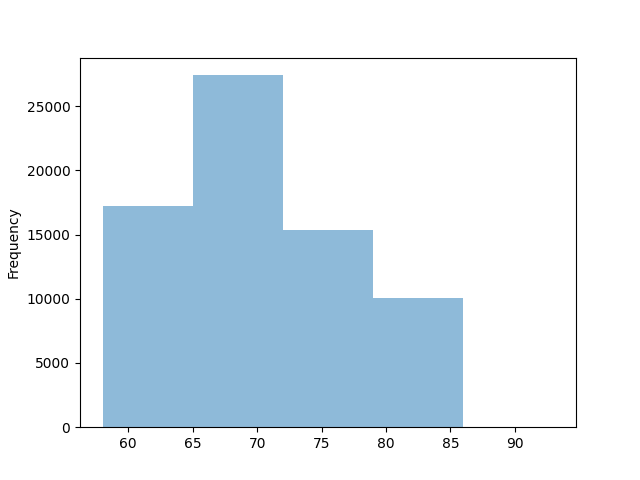

In [9]:
#we ran a histogram plot for the numeric variable age3, see cell below for interpretation.
plt.clf()
age3 = heart_csv['age3']
age3.plot.hist(bins =5, alpha = 0.5)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

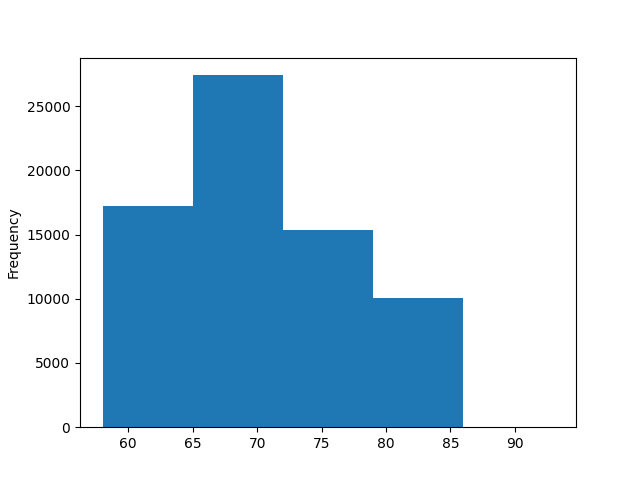

In [10]:
#we ran a histogram plot for the numeric variable age3, see cell below for interpretation.
plt.clf()
heart_csv['age3'].hist(bins=5)
%matplot plt

We can see in our age3 distribution that our data looks almost nornally distributed, with slight right-skewing. This distribution shows that our sample consists of seniors aged ~55-87 years old. Our highest number of seniors are at around 65-70 years old.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

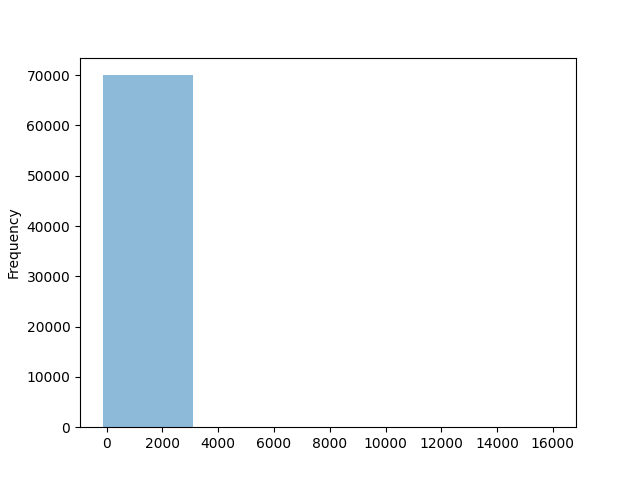

In [11]:
#we ran a histogram for the numeric variable ap_hi(systolic blood pressure, see below)
plt.clf()
ap_hi = heart_csv['ap_hi']
ap_hi.plot.hist(bins =5, alpha = 0.5)
%matplot plt

We can see that there is a compact range for systolic blood pressure, falling between 0 and ~3000, for which a normal systolic blood pressure is 120 mmHg. We do not see a normal distribution through this histogram.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

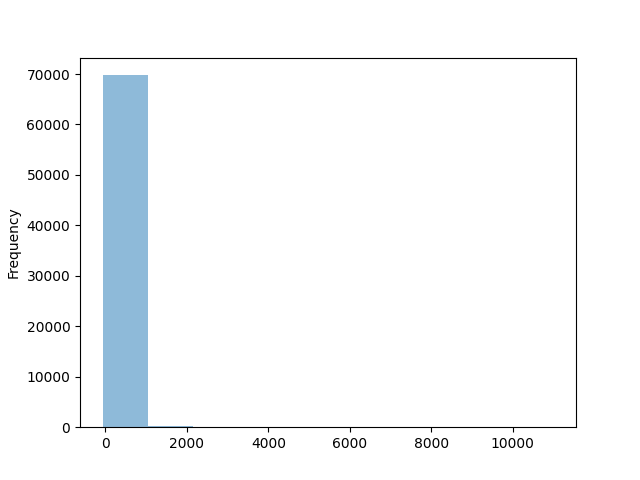

In [12]:
#we ran a histogram plot for numeric variable ap_lo (diastolic blood pressure, see below)
plt.clf()
ap_lo = heart_csv['ap_lo']
ap_lo.plot.hist(bins =10, alpha = 0.5)
%matplot plt

We can see diastolic blood pressure is also highly condensed to one area, with the entire data set range between 0 and 200 mmHg. We can observe that Ap_lo does not look like a normal distribution in this histogram.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

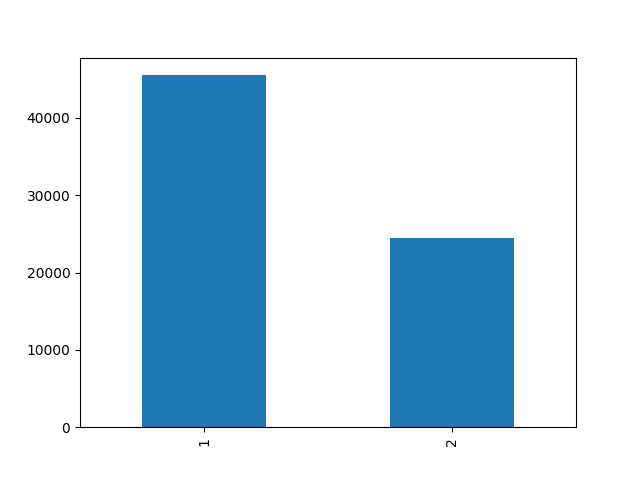

In [13]:
#we ran a barplot for the binary variable gender, see below interpretation.
plt.clf()
gender = heart_csv['gender'].value_counts().plot.bar()
%matplot plt

Our dataset consists of male and female patients, in which 1 represents male and 2 female. We can observe that the majority of patient data consists of males, and female patients are around half of the males in the sample.

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

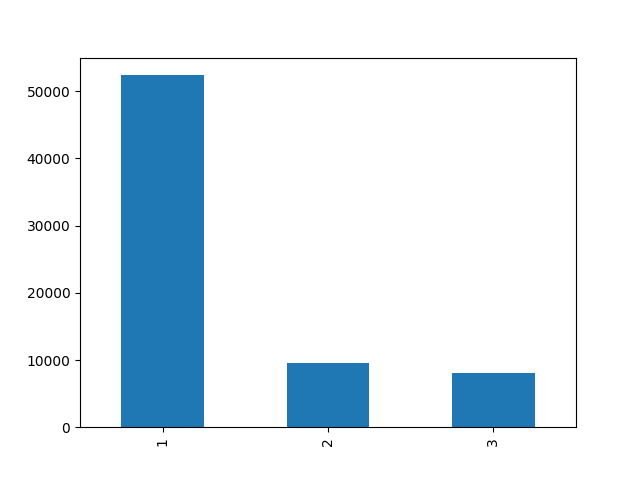

In [14]:
# create barchart to see the counts of cholesterol level 
# cholesterol
plt.clf()
chol = heart_csv['cholesterol'].value_counts().plot.bar()
%matplot plt

Based on the results, cholesterol level one has the highest results and based on the variables there should be scale of 0 - 5+ units but on the results show 1-3

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

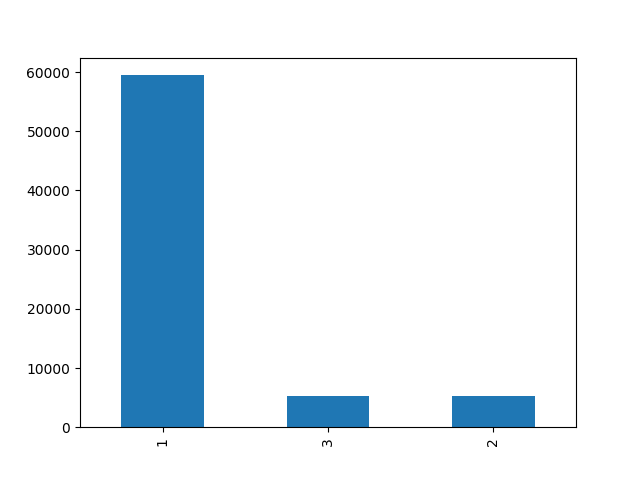

In [15]:
# create barchart to see the counts of Glucose level 
# Glucose
plt.clf()
gluc = heart_csv['gluc'].value_counts().plot.bar()
%matplot plt

Based on the results, glucose level one has the highest results

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

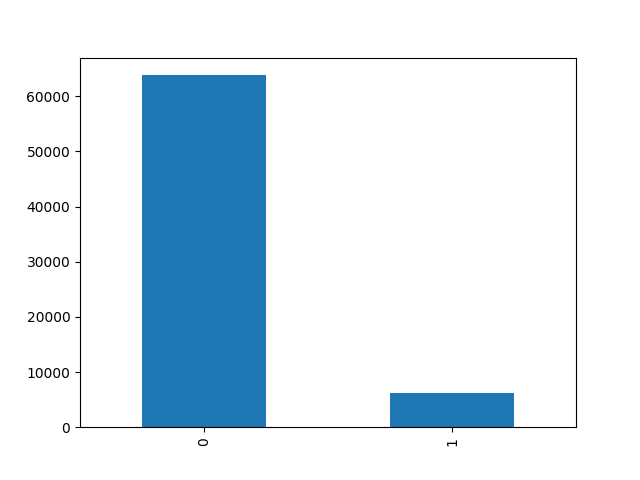

In [16]:
# create barchart to see the counts of smokers
# 1 meaning the participants that smoke and 0 meaning the participants that don't smoke
# smoke
plt.clf()
smoke = heart_csv['smoke'].value_counts().plot.bar()
%matplot plt

Based on the results, majority participants don't smoke

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

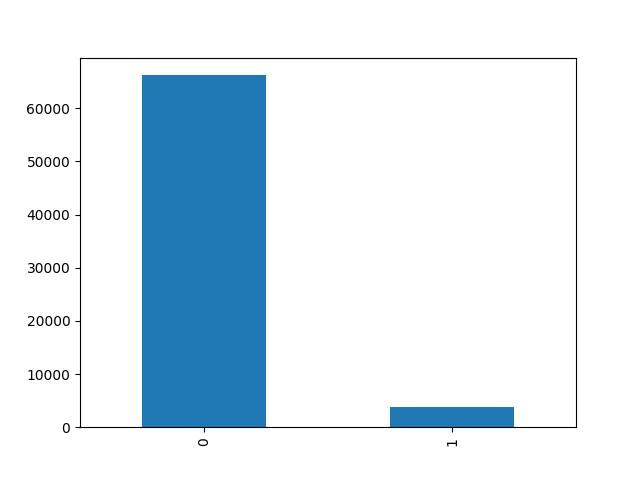

In [17]:
# create barchart to see the counts of participant that drinks 
# 1 meaning the participants that drink alcohol and 0 meaning the participants that don't drink alcohol
# alcohol
plt.clf()
alcohol = heart_csv['alco'].value_counts().plot.bar()
%matplot plt

Based on the results, majority participants dont drink alcohol

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

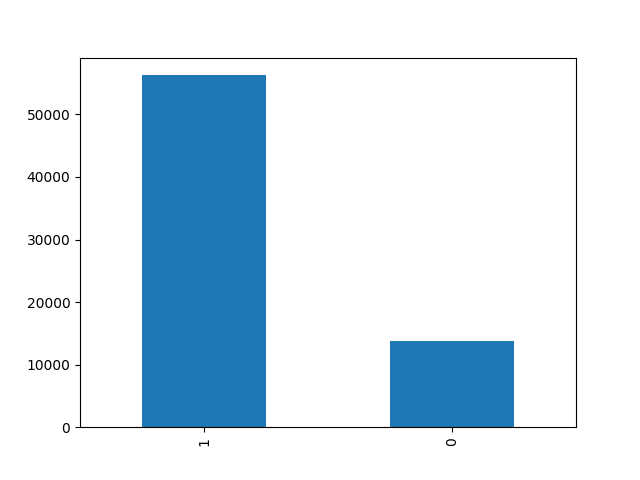

In [18]:
# create barchart to see the counts of participant that are physically active
# 1 meaning the participants that are physically active and 0 meaning the participants that are not physically active
# active
plt.clf()
active = heart_csv['active'].value_counts().plot.bar()
%matplot plt

Based on the results, majority participants are physically active

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

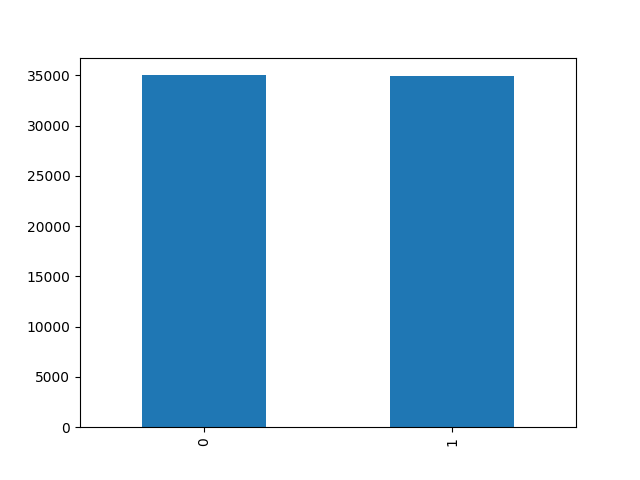

In [19]:
# create barchart to see the counts of participant that suffers from cardiovascular diseases
# 1 meaning the participants that suffers from cardiovascular diseases and 0 meaning the participants that don't suffer from cardiovascular diseases
# cardiovascular diseases
plt.clf()
cardio = heart_csv['cardio'].value_counts().plot.bar()
%matplot plt

Based on the results, participants that suffers from cardiovascular diseases have similar result as the ones that dont suffer from cardiovascular diseases

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

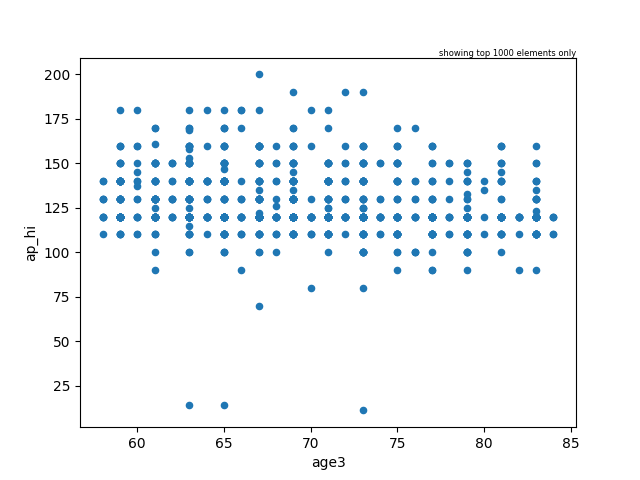

In [20]:
# create scatter plot to see relationship between age of participant and their Systolic blood pressure readings
heart_csv.plot.scatter('age3', 'ap_hi')
%matplot plt

Based on the scatter plot, there seems to be a relationship between age 60-85 with systolic blood pressure reading

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

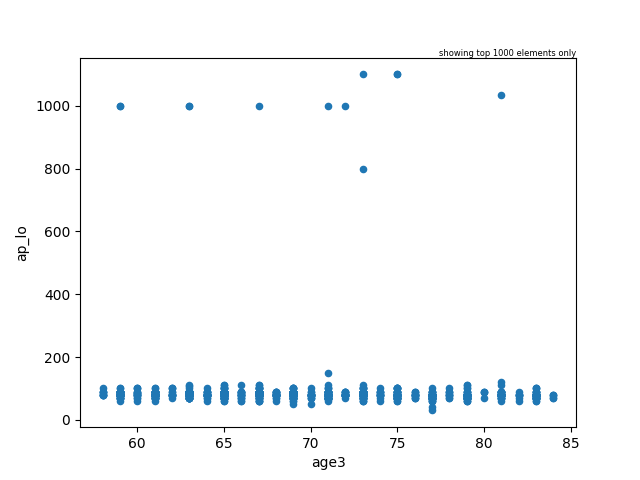

In [21]:
# create scatter plot to see relationship between age of participant and their Diastolic blood pressure readings
heart_csv.plot.scatter('age3', 'ap_lo')
%matplot plt

Based on the scatter plot, there seems to be a relationship between age 65-75 with diastolic blood pressure reading

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

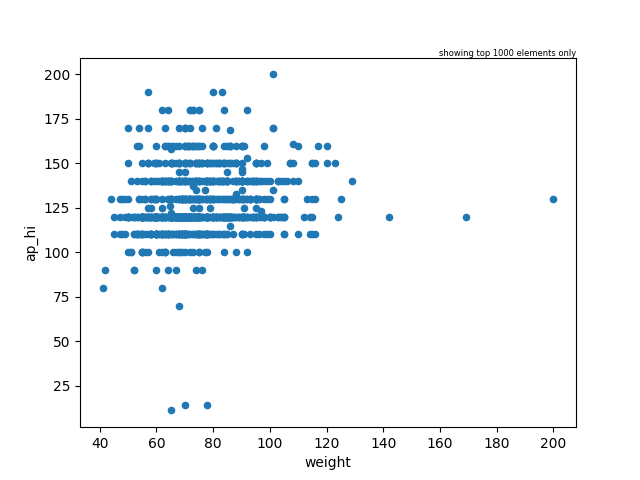

In [22]:
# create scatter plot to see relationship between weight(kg) of participant and their Systolic blood pressure readings
heart_csv.plot.scatter('weight', 'ap_hi')
%matplot plt

Based on the scatter plot, there seems to be a relationship between weight 50-100 with systolic blood pressure reading

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

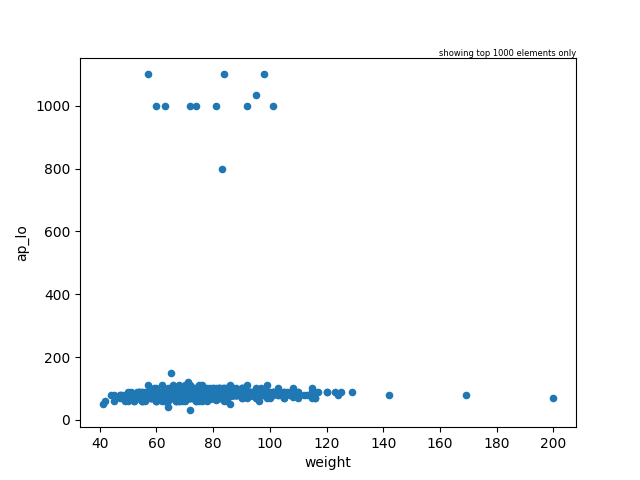

In [23]:
# create scatter plot to see relationship between weight(kg) of participant and their Diastolic blood pressure readings
heart_csv.plot.scatter('weight', 'ap_lo')
%matplot plt

Based on the scatter plot, there seems to be a relationship between weight 50-125 with systolic blood pressure reading

There are significant outliers within this dataset that may be attributed to medical data entry errors. These will be removed from the outliers.

In [24]:
#dropping outliers from the dataset; total amount dropped is 1195 rows which makes up less than 2% of our total data
no_outliers = heart_csv[(heart_csv.weight > 25)&(heart_csv.age3 > 0)&(heart_csv.height < 240)]
no_outliers

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       id  age3  gender  height  weight  ap_hi  ap_lo  cholesterol  gluc  smoke  alco  active  cardio
0       0    73       2     168    62.0    110     80            1     1      0     0       1       0
1       1    68       1     156    85.0    140     90            3     1      0     0       1       1
2       2    71       1     165    64.0    130     70            3     1      0     0       0       1
3       3    75       2     169    82.0    150    100            1     1      0     0       1       1
4       4    75       1     156    56.0    100     60            1     1      0     0       0       0
5       8    63       1     151    67.0    120     80            2     2      0     0       0       0
6       9    62       1     157    93.0    130     80            3     1      0     0       1       0
7      12    61       2     178    95.0    130     90            3     3      0     0       1       1
8      13    75       1     158    71.0    110     70            1     1      0   

In [25]:
#import libraries 
import pyspark.sql.functions as F
import pyspark.ml.feature as feat
from pyspark.ml import Pipeline
import numpy as np 
import pyspark.ml.stat as st
import pandas as pd
import pyspark.ml.classification as cl
import pyspark.ml.evaluation as ev

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
#creating correlation matrix
features_and_label = feat.VectorAssembler(
    inputCols=list(no_outliers.columns)
    , outputCol='features'
)

corr = st.Correlation.corr(
    features_and_label.transform(no_outliers.to_spark()), 
    'features', 
    'pearson'
)

print(str(corr.collect()[0][0]))
corr_pd = corr.toPandas()
output_np = np.array(corr_pd.iloc[0, 0].values).reshape(
    (corr_pd.iloc[0, 0].numRows, corr_pd.iloc[0, 0].numCols))

corr_pd = pd.DataFrame(output_np, columns=no_outliers.columns)
corr_pd.index = no_outliers.columns
corr_pd = ps.from_pandas(corr_pd)
corr_pd.to_spark(index_col='index').repartition(1).pandas_api().to_csv('s3://gba-6430-project/Spark/tmp/cor/')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

An error was encountered:
An error occurred while calling o1924.save.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 72.0 failed 4 times, most recent failure: Lost task 0.3 in stage 72.0 (TID 71) (ip-172-31-47-208.ec2.internal executor 1): java.lang.RuntimeException: Failed to run command: /usr/bin/virtualenv -p python3 --no-pip --system-site-packages virtualenv_application_1691032593746_0001_0
	at org.apache.spark.api.python.VirtualEnvFactory.execCommand(VirtualEnvFactory.scala:125)
	at org.apache.spark.api.python.VirtualEnvFactory.setupVirtualEnv(VirtualEnvFactory.scala:83)
	at org.apache.spark.api.python.PythonWorkerFactory.<init>(PythonWorkerFactory.scala:95)
	at org.apache.spark.SparkEnv.$anonfun$createPythonWorker$1(SparkEnv.scala:128)
	at scala.collection.mutable.HashMap.getOrElseUpdate(HashMap.scala:86)
	at org.apache.spark.SparkEnv.createPythonWorker(SparkEnv.scala:128)
	at org.apache.spark.api.python.BasePythonRunner.compute(PythonRunner.

In [27]:
#using univariate to select features
#exclude the label 'cardio' from features vector
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in no_outliers.columns if x != 'cardio']
    , outputCol='features'
)

#select top 6 features, store in a new column named selected
selector = feat.UnivariateFeatureSelector(
    labelCol='cardio'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("continuous"
    ).setLabelType("categorical"
    ).setSelectionThreshold(6) #select top 6 features

#create pipeline
pipeline_sel = Pipeline(stages=[vectorAssembler, selector])

model = (
    pipeline_sel
    .fit(no_outliers.to_spark())
    .transform(no_outliers.to_spark())
)

#print selected features
model.schema['selected'].metadata

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'age3'}, {'idx': 1, 'name': 'weight'}, {'idx': 2, 'name': 'ap_hi'}, {'idx': 3, 'name': 'ap_lo'}, {'idx': 4, 'name': 'cholesterol'}, {'idx': 5, 'name': 'gluc'}]}, 'num_attrs': 6}}

In [28]:
#split into train and test sets
heart_train, heart_test = (
    no_outliers.to_spark()
    .randomSplit([0.7, 0.3], seed=666)
)

#convert all features to vector except for 'cardio'
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in no_outliers.columns if x != 'cardio']
    , outputCol='features'
)

#select top 6 predictors
selector = feat.UnivariateFeatureSelector(
    labelCol='cardio'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("continuous"
    ).setLabelType("categorical"
    ).setSelectionThreshold(6) #select top 6 features

#create a multinomial regression object
#'cardio' has 2 outcomes
logReg_obj = cl.LogisticRegression(
    labelCol='cardio'
    , featuresCol=selector.getOutputCol()
    , regParam=0.01
    , elasticNetParam=1.0
    , family='multinomial'
)

#create pipeline of 1)vector, 2)chisquare selector, 3)logistic regression
pipeline = Pipeline(
    stages=[
        vectorAssembler
        , selector
        , logReg_obj
    ])
#train the model
pModel = pipeline.fit(heart_train)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
pModel.stages[-1]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

LogisticRegressionModel: uid=LogisticRegression_3a0ab459f019, numClasses=2, numFeatures=6

In [30]:
#apply the model to test set
logReg_model = (
    pModel
    .transform(heart_test)
)

results_logReg = logReg_model.select('cardio', 'probability', 'prediction')

#evaluate performance of the multinomial model (2 classes)
evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='cardio')

(
    #F-1 score
    evaluator.evaluate(results_logReg)
    #weighted precision
    , evaluator.evaluate(
        results_logReg
        , {evaluator.metricName: 'weightedPrecision'}
    ) 
    #accuracy
    , evaluator.evaluate(
        results_logReg
        , {evaluator.metricName: 'accuracy'}
    )
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.668780313661258, 0.6701214493083814, 0.6691473017092375)

In [31]:
selected_cols = ([x['name'] for x in logReg_model.schema['selected'].metadata['ml_attr']['attrs']['numeric']])

#print model coefficients
#for a binomial model use coefficients instead of coefficientMatrix
pd.set_option('display.max_columns', 10)
pd.DataFrame(pModel.stages[-1].coefficientMatrix.toArray(), columns=selected_cols).head(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

       age3    weight     ap_hi     ap_lo  cholesterol  gluc
0  0.028139 -0.009085 -0.003873 -0.000179    -0.236831   0.0
1 -0.028139  0.009085  0.003873  0.000179     0.236831   0.0

After checking coefficients, dropping glucose as dependent variable

In [32]:
#Random Forest
rf_obj = cl.RandomForestClassifier(
    labelCol='cardio'
    , featuresCol=selector.getOutputCol()
    , minInstancesPerNode=10
    , numTrees=10
)

pipeline = Pipeline(
    stages=[vectorAssembler, selector, rf_obj]
)

pModel = pipeline.fit(heart_train)

rf_obj_trained = (
    pModel
    .transform(heart_test)
)
results_rf = rf_obj_trained.select('cardio', 'probability', 'prediction')

evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='cardio')

(
    evaluator.evaluate(results_rf)
    , evaluator.evaluate(
        results_rf
        , {evaluator.metricName: 'weightedPrecision'}
    )
    , evaluator.evaluate(
        results_rf
        , {evaluator.metricName: 'accuracy'}
    )
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(0.7287783168012436, 0.7330099124588385, 0.7296427885538698)

Tune hyperparameters for both models (regParam, elasticNetParam,
ChiSqSelector. numTopFeatures, minInstancesPerNode) (60 points)

In [33]:
import pyspark.ml.tuning as tune

vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in no_outliers.columns if x != 'cardio']
    , outputCol='features')

selector = feat.UnivariateFeatureSelector(
    labelCol='cardio'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("continuous"
    ).setLabelType("categorical"
    ).setSelectionThreshold(6) #select top 6 features

logReg_obj = cl.LogisticRegression(
    labelCol='cardio'
    , featuresCol=selector.getOutputCol()
    , family='multinomial'
)


#use ParamGridBuilder to build a grid of parameters
logReg_grid = (
    tune.ParamGridBuilder()
    .addGrid(logReg_obj.regParam
            , [0.0, 0.5, 1.0]
        )
    .addGrid(logReg_obj.elasticNetParam
            , [0.0, 0.5, 1.0]
        )
    .build()
)

logReg_ev = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
        , labelCol='cardio')

# use K-fold cross validation for grid search
# CrossValidator binds all of these together
cross_v = tune.CrossValidator(
    estimator=logReg_obj
    , estimatorParamMaps=logReg_grid
    , evaluator=logReg_ev
)

pipeline = Pipeline(stages=[vectorAssembler, selector])
data_trans = pipeline.fit(heart_train)

logReg_modelTest = cross_v.fit(
    data_trans.transform(heart_train)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-33:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [34]:
#logistic regression parameters
print('Best params - regParam: {}, elasticNetParam: {}'.format(
    logReg_modelTest.bestModel._java_obj.getRegParam(),
      logReg_modelTest.bestModel._java_obj.getElasticNetParam()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best params - regParam: 0.0, elasticNetParam: 0.0

Exception in thread cell_monitor-34:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [35]:
#logistic regression result
tuning_results = pd.DataFrame([list(x.values()) for x in logReg_grid], columns=['regParam', 'elasticNetParam'])
tuning_results['F-1'] = logReg_modelTest.avgMetrics
tuning_results.sort_values('F-1', ascending=False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   regParam  elasticNetParam       F-1
0       0.0              0.0  0.716522
1       0.0              0.5  0.716522
2       0.0              1.0  0.716522
3       0.5              0.0  0.645808
6       1.0              0.0  0.643644
4       0.5              0.5  0.334913
5       0.5              1.0  0.334913
7       1.0              0.5  0.334913
8       1.0              1.0  0.334913

Exception in thread cell_monitor-35:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [36]:
# measure performance of best model for logistic regression
data_trans_test = data_trans.transform(heart_test)
results = logReg_modelTest.transform(data_trans_test)

print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'f1'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedPrecision'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedRecall'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'accuracy'}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-36:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



0.7156004680514805
0.7181480549487133
0.7161513347416939
0.7161513347416939

In [37]:
trainingSummary = logReg_modelTest.bestModel.summary
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# Per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))
    
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-37:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



objectiveHistory:
0.6931431264369496
0.6896211315046178
0.6345468303028956
0.6296525321427244
0.6271382530394723
0.6256649238296038
0.6146247800123391
0.611171940439284
0.6013069305928639
0.5995492045139035
0.5971395048189697
0.596641592346176
0.5964971778992358
0.5964881256878338
0.5964878702625747
0.5964878299247968
0.5964878269584231
0.5964878260534556
0.5964878260360212
False positive rate by label:
label 0: 0.32827479296699713
label 1: 0.23611730823834828
True positive rate by label:
label 0: 0.7638826917616517
label 1: 0.6717252070330029
Precision by label:
label 0: 0.700621302875851
label 1: 0.7388163503387625
Recall by label:
label 0: 0.7638826917616517
label 1: 0.6717252070330029
F-measure by label:
label 0: 0.7308856632771871
label 1: 0.7036752136752136
Accuracy: 0.7179351584428263
FPR: 0.28232725964817174
TPR: 0.7179351584428264
F-measure: 0.7173191793026279
Precision: 0.7196644464803409
Recall: 0.7179351584428264

In [38]:
import pyspark.ml.tuning as tune

vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in no_outliers.columns if x != 'cardio']
    , outputCol='features')

selector = feat.UnivariateFeatureSelector(
    labelCol='cardio'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("continuous"
    ).setLabelType("categorical"
    ).setSelectionThreshold(6) #select top 6 features


rf_obj = cl.RandomForestClassifier(
    labelCol='cardio'
    , featuresCol=selector.getOutputCol()
    , minInstancesPerNode=10
    , numTrees=10
)


#ParamGridBuilder to build a grid of parameters
rf_grid = (
    tune.ParamGridBuilder()
    .addGrid(rf_obj.minInstancesPerNode
            , [5, 10, 20]
        )
    .addGrid(rf_obj.maxDepth
            , [10, 20]
        )
    .build()
)

rf_ev = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='cardio')

# use K-fold cross validation for grid search
# CrossValidator binds all of these together
# default value is k=3
cross_v = tune.CrossValidator(
    estimator=rf_obj
    , estimatorParamMaps=rf_grid
    , evaluator=rf_ev
)

pipeline = Pipeline(stages=[vectorAssembler, selector])
data_trans = pipeline.fit(heart_train)

rf_modelTest = cross_v.fit(
    data_trans.transform(heart_train)
)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-38:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [39]:
#finding best parameters for random forest
print('Best params - MaxDepth: {}, MinInstancesPerNode: {}'.format(
    rf_modelTest.bestModel._java_obj.getMaxDepth(),
      rf_modelTest.bestModel._java_obj.getMinInstancesPerNode()))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Best params - MaxDepth: 10, MinInstancesPerNode: 20

In [40]:
#random forest results 
tuning_results = pd.DataFrame([list(x.values()) for x in rf_grid], columns=['minInstancesPerNode', 'maxDepth'])
tuning_results['F-1'] = rf_modelTest.avgMetrics
tuning_results.sort_values('F-1', ascending=False)

VBox()

Exception in thread cell_monitor-39:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

   minInstancesPerNode  maxDepth       F-1
4                   20        10  0.733475
0                    5        10  0.732144
2                   10        10  0.731244
5                   20        20  0.730764
3                   10        20  0.728117
1                    5        20  0.723327

Exception in thread cell_monitor-40:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



In [41]:
# measure performance of best model using random forest
data_trans_test = data_trans.transform(heart_test)
results = rf_modelTest.transform(data_trans_test)

print(rf_ev.evaluate(results, {rf_ev.metricName: 'f1'}))
print(rf_ev.evaluate(results, {rf_ev.metricName: 'weightedPrecision'}))
print(rf_ev.evaluate(results, {rf_ev.metricName: 'weightedRecall'}))
print(rf_ev.evaluate(results, {rf_ev.metricName: 'accuracy'}))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-41:
Traceback (most recent call last):
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/mnt/notebook-env/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in cell_monitor
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
  File "/mnt/notebook-env/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 154, in <listcomp>
    job_group_filtered_jobs = [job for job in jobs_data if job['jobGroup'] == str(statement_id)]
KeyError: 'jobGroup'



0.7281037829945506
0.730522906049329
0.7285865181486461
0.7285865181486461